패키지 참조 -> 데이터 셋 준비 -> 데이터 전처리 -> 탐색적 데이터 분석 -> 데이터 셋 분할 -> 모델 개발 -> 학습 결과 평가 -> 학습 결과 적용

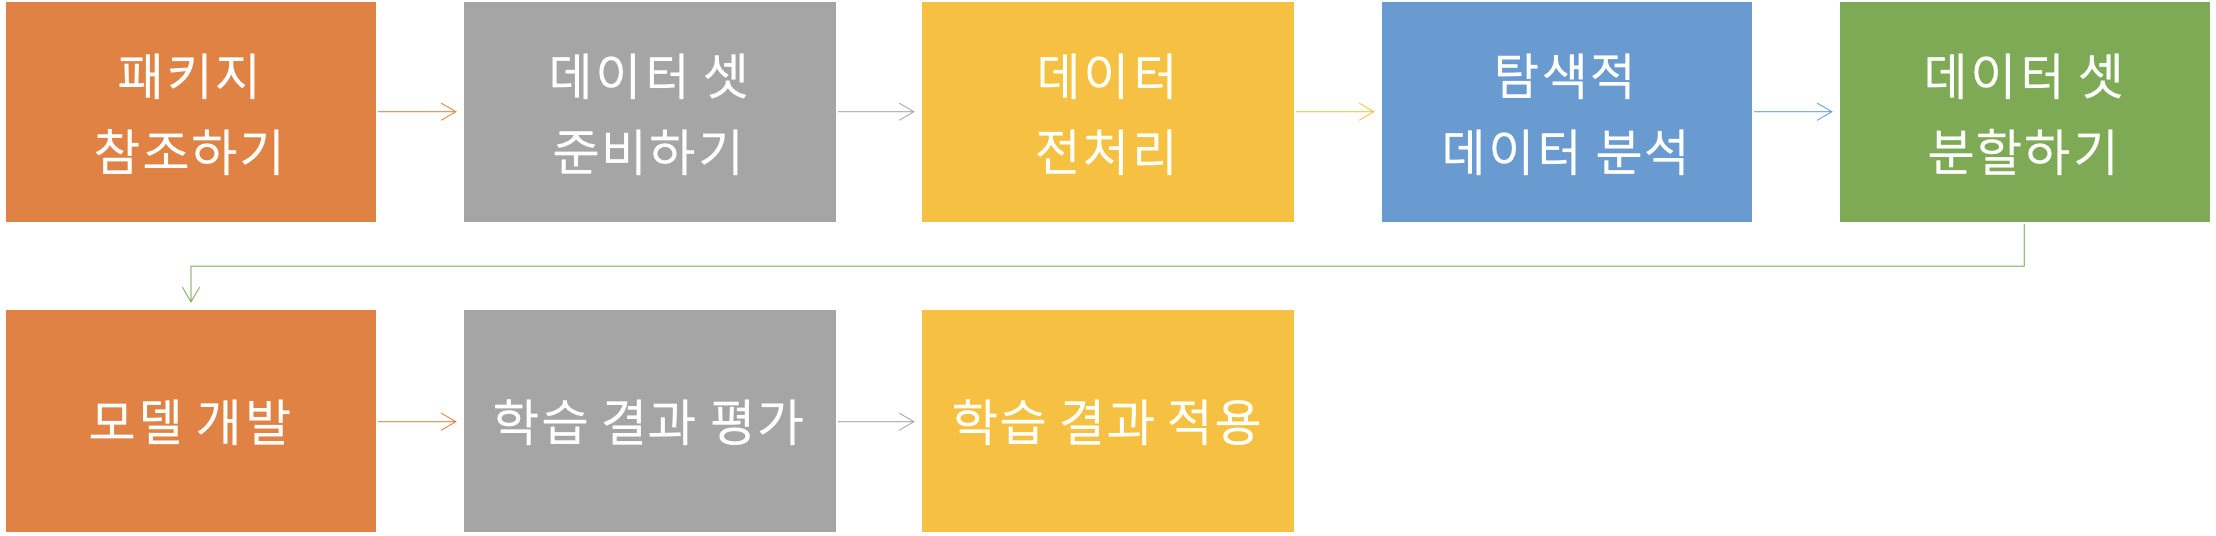

분석 프로세스를 진행한 이유와 해당 프로세서를 통해 얻은 결론을 설명
- 모든 단계는 목적과 근거를 제시

>머신러닝 - 소숫점 처리에 뛰어남

# 로지스틱 회귀 - 타이타닉 생존률 `예측`

로지스틱회귀는 설명력을 사용하지 않음

분류는 예측

## #01. 패키지

In [1]:
import sys
sys.path.append("../../")
import helper

import numpy as np
from pandas import read_excel, DataFrame, get_dummies
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

## #02. 데이터 준비

In [3]:
origin = read_excel("https://data.hossam.kr/E05/titanic.xlsx")
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
origin.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## #03. 데이터 전처리

### 결측치 확인

In [5]:
origin.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### 결측치 정제

#### 객실번호(`Cabin`)

선실이 부여되지 않은 경우 객실 등급에 따른 차이가 있는지 여부를 확인

In [6]:
print(origin.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [8]:
df_tmp = origin.filter(['Pclass', 'Cabin']).query('Cabin.isnull()')
df_tmp.fillna(0, inplace=True)
df_tmp.groupby('Pclass').count()

,Cabin
Pclass,
1,40
2,168
3,479


> 객실 번호는 생존 여부에 영향이 없을 것으로 판단하고 변수 자체를 제거 (열단위 제거)

In [9]:
df1 = origin.drop('Cabin', axis = 1)
df1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


#### 탑승지(`Embarked`)

탑승지 데이터가 결측치인 경우는 2건 밖에 되지 않기 때문에 데이터 정제 과정에서 제거 (행단위)

In [10]:
df2 = df1.query('Embarked.notnull()')   #null이 아닌 Embarked의 행만 추출
df2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


#### 나이(`Age`)를 중앙값으로 대체

나이의 경우 탑승객의 생존 여부에 중요한 영향을 미치는 요인이라고 짐작하고 삭제하지 않기로 결정하였다.

연속형 데이터의 결측치를 대체하기에 가장 적합한 값은 중앙값이므로 중앙값으로 대체한다.

In [11]:
df3 = df2.copy()
df3['Age'].fillna(df3['Age'].median(), inplace=True)
df3.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

### 불필요한 필드 제거

#### 탑승객 번호

탑승객 번호는 `단순한 일련번호`이므로 생존률에 영향을 주지 않는 값이라고 판단하고 이 값을 인덱스로 설정하였다.

In [12]:
# PassengerId를 DF의 Index로
df4 = df3.set_index('PassengerId')
df4.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


#### 이름과 티켓번호

생존 여부에 영향을 주지 않는다고 판단하고 제거

In [13]:
df5 = df4.drop(['Name', 'Ticket'], axis=1)
df5.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


### 명목형 처리(더미변수화)

- `더미변수`는 `변수의 값이 최소 2개를 초과`할 경우 수행. 아니면 단순 category 타입으로 변경.

범주형(명목형) 데이터(카테고리가 1~3등급)를 각 카테고리별로 나누어 표현 - 명목형은 계산할 수 있는 값이 아니기 때문

ex) 태아의 성별, 위암 등급, 승무원의 등급

>명목형으로 의심되면 일단 value_counts()로 확인

>type, shape, info 등을 사용해 객체 형태 및 정보를 확인 가능

In [14]:
# origin['Pclass'].value_counts()
# origin['Sex'].value_counts()
df5['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [15]:
cda_df = get_dummies(df5, columns=['Pclass', 'Sex', 'Embarked'], drop_first=True, dtype='int')
cda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 1 to 891
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    889 non-null    int64  
 1   Age         889 non-null    float64
 2   SibSp       889 non-null    int64  
 3   Parch       889 non-null    int64  
 4   Fare        889 non-null    float64
 5   Pclass_2    889 non-null    int32  
 6   Pclass_3    889 non-null    int32  
 7   Sex_male    889 non-null    int32  
 8   Embarked_Q  889 non-null    int32  
 9   Embarked_S  889 non-null    int32  
dtypes: float64(2), int32(5), int64(3)
memory usage: 59.0 KB


In [16]:
cda_df.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,0,22.0,1,0,7.2500,0,1,1,0,1
2,1,38.0,1,0,71.2833,0,0,0,0,0
3,1,26.0,0,0,7.9250,0,1,0,0,1
4,1,35.0,1,0,53.1000,0,0,0,0,1
5,0,35.0,0,0,8.0500,0,1,1,0,1


## #04. 탐색적 데이터 분석

> `E05`의 연습문제 2번으로 진행한바 있으므로 생략

## #05. 데이터셋 분할

### 랜덤시드 고정

In [17]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [18]:
x = cda_df.drop('Survived', axis=1)
x.head()

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
1,22.0,1,0,7.2500,0,1,1,0,1
2,38.0,1,0,71.2833,0,0,0,0,0
3,26.0,0,0,7.9250,0,1,0,0,1
4,35.0,1,0,53.1000,0,0,0,0,1
5,35.0,0,0,8.0500,0,1,1,0,1


In [21]:
type(x)

pandas.core.frame.DataFrame

In [20]:
# y = cda_df['Survived']    #x에 맞게 y도 DF 타입으로
y = cda_df[['Survived']]
y.head()

,Survived
PassengerId,
1,0
2,1
3,1
4,1
5,0


### 데이터 표준화 

> 일단 생략 - 표준화를 했다면 예측을 위한 값도 표준화 후 삽입해야하기 때문(복잡해짐)

### 훈련 데이터와 검증 데이터로 분할

In [22]:
# 표준화 미진행 - x,y 사용
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((622, 9), (267, 9), (622, 1), (267, 1))

## #06. 모델 개발

### 모델 정의

> [relu], sigmoid, rmsporp, binary_crossentropy, acc

- `input_shape`은 독립변수 수
- `Dense` 신경망 개수의 수에 따라서 모델의 성능에 차이가 발생
    - 직감으로 맞춤(다른 방법 없음) 보통 16 또는 32 이상
    - 최적의 값을 직접 탐색(너무 많으면 컴퓨터 다운)
- `activation`은 모델과 분석 종류에 따라서 다름 
    - 보통 시작은 relu, 분류는 sigmoid, 회귀는 linear
- `optimizer`은 모르면 Adam
- `epochs`는 많아도 크게 상관이 없음
- 2차항을 하고 싶다면 sklearn으로 2차항 생성 후 Sequential에 입력

In [23]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(9, )))
model.add(Dense(1, activation='relu'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                320       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 353 (1.38 KB)
Trainable params: 353 (1.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

- `epochs`는 많아도 크게 상관이 없음(단, 너무 크면 오래 걸리고 오차가 증가)
    - `callback`을 사용해 모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 모니터링
    - `EarlyStopping` 콜백과 같이 `patience` 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - `ReduceLROnPlateau` `EarlyStopping` 콜백과 같이 `patience` 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - `ModelCheckpoint` 지정한 평가지표를 기준으로 가장 뛰어난 성능을 보여주는 모델을 저장 할 때 사용

In [24]:
result = model.fit(x_train, y_train, epochs = 500, validation_data = (x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500
20/20 [==============================] - 1s 18ms/step - loss: 5.0082 - acc: 0.6463 - val_loss: 4.5744 - val_acc: 0.6816 - lr: 0.0010
Epoch 2/500
20/20 [==============================] - 0s 4ms/step - loss: 4.8825 - acc: 0.6608 - val_loss: 4.4244 - val_acc: 0.6929 - lr: 0.0010
Epoch 3/500
20/20 [==============================] - 0s 5ms/step - loss: 4.8568 - acc: 0.6592 - val_loss: 4.4188 - val_acc: 0.6966 - lr: 0.0010
Epoch 4/500
20/20 [==============================] - 0s 6ms/step - loss: 4.8306 - acc: 0.6624 - val_loss: 4.4216 - val_acc: 0.6891 - lr: 0.0010
Epoch 5/500
20/20 [==============================] - 0s 9ms/step - loss: 4.8255 - acc: 0.6608 - val_loss: 4.5656 - val_acc: 0.6854 - lr: 0.0010
Epoch 6/500
20/20 [==============================] - 0s 10ms/step - loss: 4.7480 - acc: 0.6511 - val_loss: 4.2489 - val_acc: 0.6704 - lr: 0.0010
Epoch 7/500
20/20 [==============================] - 0s 5ms/step - loss: 4.7707 - acc: 0.6447 - val_loss: 4.2373 - val_acc: 0.6742 - l

## #07. 학습결과 평가

### 기본적인 머신러닝 학습률 평가

08-다중선형회귀.ipynb (데이터프레임화, 손실률/정확도 시각화)참고

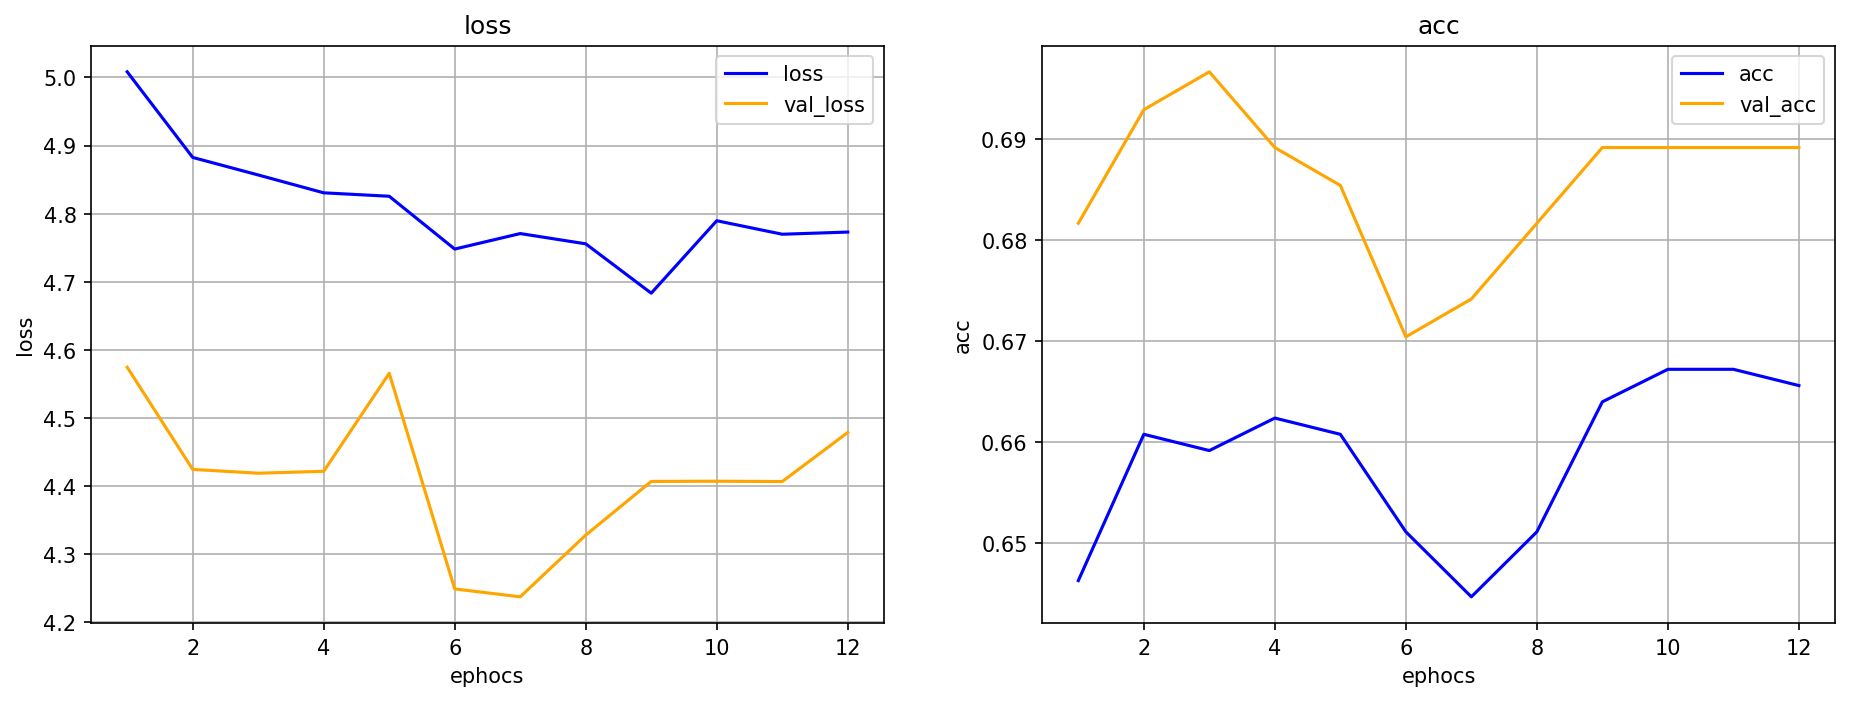

,loss,acc,val_loss,val_acc,lr
epochs,,,,,
1,5.008229,0.646302,4.574368,0.681648,0.0010
2,4.882531,0.660772,4.424430,0.692884,0.0010
3,4.856792,0.659164,4.418818,0.696629,0.0010
4,4.830561,0.662379,4.421621,0.689139,0.0010
5,4.825515,0.660772,4.565557,0.685393,0.0010
6,4.747973,0.651125,4.248914,0.670412,0.0010
7,4.770746,0.644695,4.237295,0.674157,0.0010
8,4.755663,0.651125,4.327942,0.681648,0.0010
9,4.683191,0.663987,4.406741,0.689139,0.0010


In [25]:
helper.tf_result_plot(result)

In [26]:
evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률 : %f, 최종 훈련 정확도 : %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률 : %f, 최종 검증 정확도 : %f" % (evaluate2[0], evaluate2[1]))

20/20 [==============================] - 0s 2ms/step - loss: 4.7512 - acc: 0.6720
최종 훈련 손실률 : 4.751192, 최종 훈련 정확도 : 0.672026
9/9 [==============================] - 0s 1ms/step - loss: 4.4787 - acc: 0.6891
최종 검증 손실률 : 4.478674, 최종 검증 정확도 : 0.689139


### 로지스틱 회귀 결과 검정

> helper 기능 추가

In [27]:
logit_result = helper.tf_logit_result(model, result, x_train, y_train)

20/20 [==============================] - 0s 1ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                320       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 353 (1.38 KB)
Trainable params: 353 (1.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
logit_result.cmdf

,Negative,Positive
True,275,86
False,118,143


In [29]:
logit_result.odds_rate_df

array([1.1449374], dtype=float32)

In [30]:
logit_result.result_df.T
# helper.prettyPrint(logit_result.result_df.T)

,0
정확도(Accuracy),0.672026
정밀도(Precision),0.547893
"재현율(Recall, TPR)",0.624454
"위양성율(Fallout, FPR)",0.300254
"특이성(Specificity, TNR)",0.699746
RAS,0.662100
f1_score,0.583673


## #08. 학습 결과 적용

### 실제 데이터로 예측

#### 예측을 위한 데이터프레임 준비

In [31]:
test_df = DataFrame({
    'dicaprio': [19, 0, 0, 0, 0, 1, 1, 0, 0],  # 영화속 남자 주인공 데이터
    'winslet': [17, 1, 2, 100, 0, 0, 0, 1, 0], # 영화속 여자 주인공 데이터
    'someone': [41, 1, 0, 50, 1, 0, 1, 0, 0]  # 임의의 데이터(본인이나 주변인)
}, index=['Age','SibSp','Parch','Fare','Pclass_2','Pclass_3','Sex_male','Embarked_Q','Embarked_S'])
test_df

,dicaprio,winslet,someone
Age,19,17,41
SibSp,0,1,1
Parch,0,2,0
Fare,0,100,50
Pclass_2,0,0,1
Pclass_3,1,0,0
Sex_male,1,0,1
Embarked_Q,0,1,0
Embarked_S,0,0,0


#### 결과 예측

In [32]:
results = model.predict(test_df.T)
data_count, case_count = results.shape
print("%d개의 임의의 데이터는 %d개의 경우의 수를 갖는다." % (data_count, case_count))
print(results)

1/1 [==============================] - 0s 66ms/step
3개의 임의의 데이터는 1개의 경우의 수를 갖는다.
[[ 0.      ]
 [21.810017]
 [ 8.484571]]


In [33]:
for i, v in enumerate(results.flatten()):
    print("%s의 생존 확률은 %0.1f%% 입니다." % (test_df.columns[i], v*100))

dicaprio의 생존 확률은 0.0% 입니다.
winslet의 생존 확률은 2181.0% 입니다.
someone의 생존 확률은 848.5% 입니다.
